In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
events = np.loadtxt("../data_processed/events_refact.txt")

In [25]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [26]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

In [27]:
t_start = events[0, 0]

In [28]:
last_time = np.zeros(shape)
time_difference = np.zeros(shape)
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x == shape[1] -1:
        continue
    
    if last_time[y, x+1] != 0:
        time_difference[y, x] = e[0] - last_time[y, x+1]

In [29]:
conv_shape = (3, 3)
conv_stride = (3, 3)
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
dict_px = {} 
dict_t = {}
for x in range(time_difference.shape[1]):
    for y in range(time_difference.shape[0]):
        if time_difference[y, x] == 0:
            continue

        x_c = int(x / conv_stride[0])
        y_c = int(y / conv_stride[1])

        if (y_c, x_c) in dict_px:
            dict_px[y_c, x_c].append(time_difference[y, x])
        else:
            dict_px[y_c, x_c] = [time_difference[y, x]]
            
        if (y_c, x_c) in dict_t:
            dict_t[y_c, x_c].append(last_time[y, x])
        else:
            dict_t[y_c, x_c] = [last_time[y, x]]

In [30]:
time_diff_med = np.zeros(result_shape)
for k in dict_px:
    y = k[0]
    x = k[1]
    if len(dict_px[k]) <= 2:
        continue
    time_diff_med[y, x] = np.median(dict_px[k])

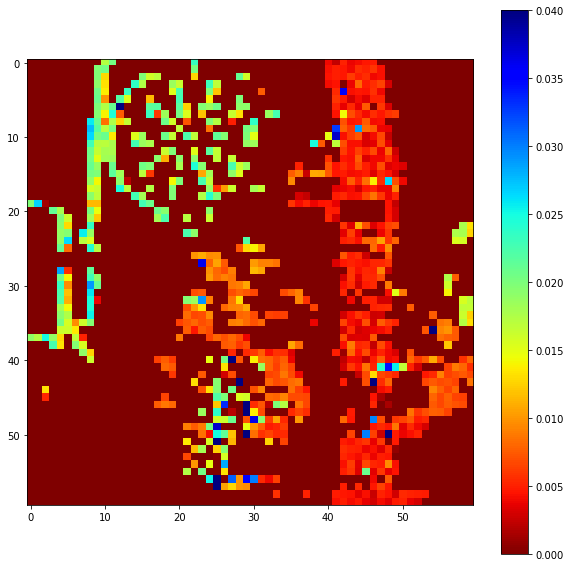

In [31]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(time_diff_med, cmap="jet_r", vmax=0.04)
plt.colorbar(mappable=m)

In [32]:
time_diff_med_m = np.ma.masked_where(time_diff_med<=0, time_diff_med)
u = np.divide(1, time_diff_med_m, where=time_diff_med > 0)

In [33]:
v = 0.2901460156636141

In [34]:
f = 335.419462958

In [35]:
d = np.divide(f, u, where=u>0.0) * v

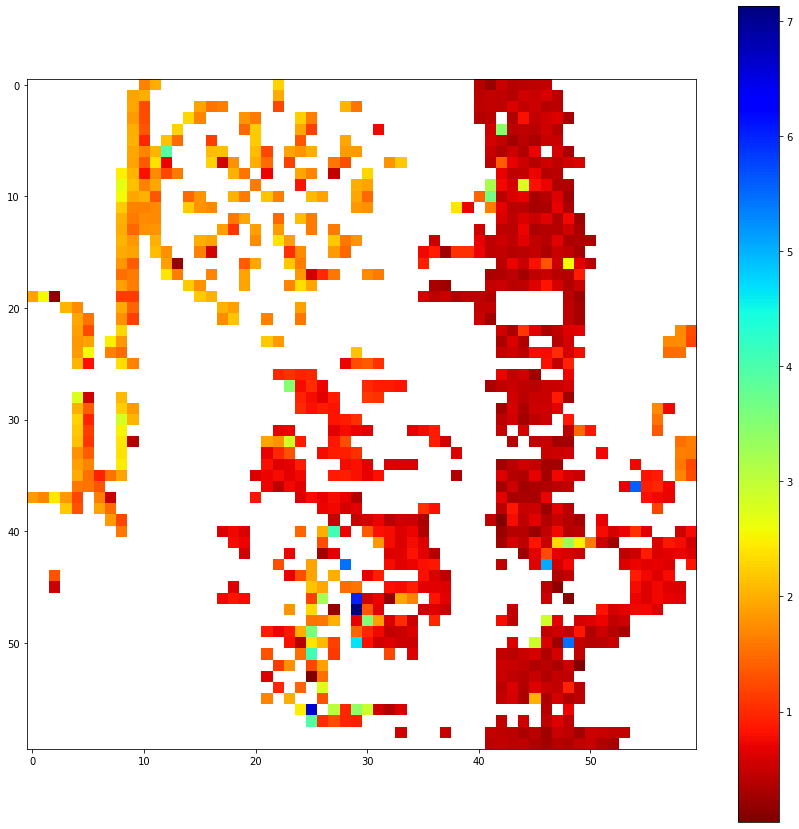

In [36]:
plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r")
plt.colorbar(m)

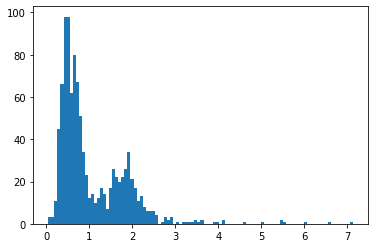

In [37]:
plt.hist(d.compressed(), 100);

In [38]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x] or d.data[y, x] > 3:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [39]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r")
ax.set_zlim3d([0, 3])
plt.show()

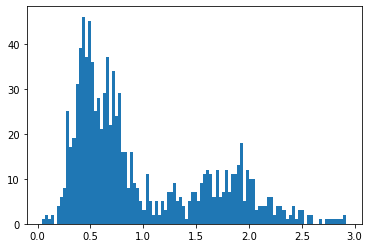

In [18]:
%matplotlib inline
plt.hist(points[:,2], 100);

In [19]:
img_corr = np.copy(d.data)
img_count = np.zeros(img_corr.shape)

for x in range(img_corr.shape[1] -1, -1, -1):
    for y in range(img_corr.shape[0]):
        if d.mask[y, x]:
            img_corr[y, x] = 0
            continue
        if x == 0:
            continue
        if img_corr[y, x] == 0:
            continue

        if not d.mask[y, x-1] and img_corr[y, x-1] != 0:
            img_corr[y, x-1] += img_corr[y, x]
            img_corr[y, x] = 0
            img_count[y, x-1] += img_count[y, x] + 1
            
img_corr_d = np.divide(img_corr, img_count, where=img_count!=0)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


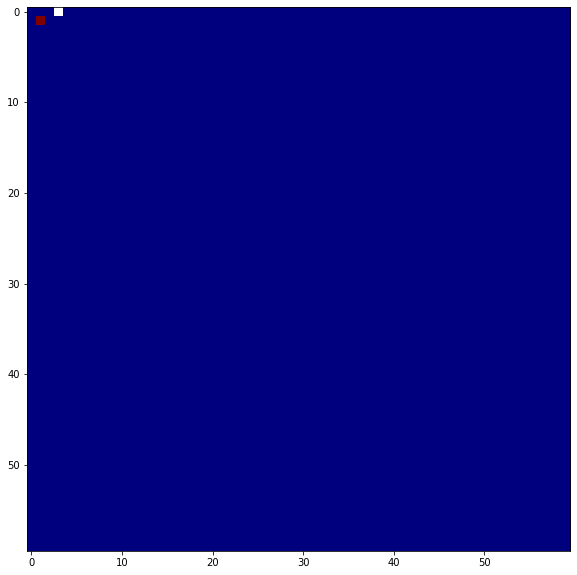

In [20]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(img_corr_d, cmap="jet_r")
#plt.colorbar(mappable=m)

In [21]:
img_corr_m = np.ma.masked_where(img_corr_d<=0, img_corr_d)
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if img_corr_d[y, x] == 0:
            continue
        points.append([x, y, img_corr_d[y, x]])
points = np.array(points)

In [22]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r")
ax.set_zlim3d([0.1, 5])
plt.show()

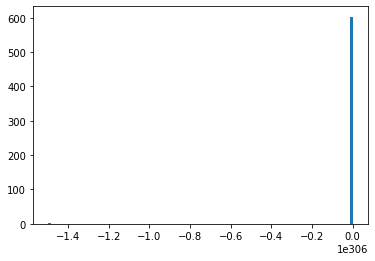

In [23]:
%matplotlib inline
plt.hist(points[:,2], 100);